## Introduction to Deep Learning

### Linear layer and single-layer perceptron

Given the input vector $x$, a _linear layer_ effectively calculates the output
vector $\hat{y}$ by the following equation, where $W$ and $b$ are the layer's
weight matrix and bias vector, respectively:

$$ \hat{y} = W \cdot x + b $$

Note that linear layer is **not** a linear transformation, despite its name. We
could easily create a linear layer by the following code snippet. Here, we
assume $\hat{y}$ a 100-dimension vector and $x$ a 300-dimension vector.


In [1]:
import torch

W = torch.randn((100, 300))
x = torch.randn(300)
b = torch.randn(100)

y_hat = W @ x + b
y_hat.shape

torch.Size([100])

Yes, right, it's meaningless. The code just creates a random matrix and two
random vectors, then wastes some electricity by matrix multiplying and adding
them. Still, we've got the point:

- In pytorch, matrices and vectors could be multiplied with the operator `@`.
  Additionally, function `torch.mm()` could do the same job.
- We can get the "shape" of a vector (a matrix, or, as in PyTorch docs, a
  _tensor_) with the property `x.shape`. Additionally, method `x.size()` could
  do the same job.

Of course, writing `W`, `b` every time using such layer is a bad idea, and as
expected, PyTorch has a solution to this problem: a
[`Linear` class](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).


In [2]:
from torch import nn

# Note that the order of the dimensions are reversed
linear = nn.Linear(300, 100)

# Ignore the following two lines, this is just to make sure that
# the parameters are the same with the previous code
from torch.nn.parameter import Parameter

linear.weight = Parameter(W)
linear.bias = Parameter(b)

# Calculate the output
y_hat_nn = linear(x)

# Check for correctness
torch.allclose(y_hat, y_hat_nn)

True

Wondering why not just test equivalence? It's because of the
[tradeoff between range and precision](https://en.wikipedia.org/wiki/Floating-point_arithmetic).
Most floating point arithmetics are not exact; thus, testing the equality of two
floating point numbers is dangerous in most cases. This subject is beyond our
scope, so we'll just go on. However, it is an interesting subject, so
consider reading the linked Wikipedia article. It really helps debug some
related problems.

Now, time to introduce an _activation function_. This is required because
multiple linear layers is just another single linear layer plus excessive math:

$$
\begin{aligned}
\hat{y} &= W_2 \cdot (W_1 \cdot x + b_1) + b_2 \\
		&= W_2 \cdot W_1 \cdot x + W_2 \cdot b_1 + b_2 \\
		&= W' \cdot x + b'
\end{aligned}
$$

Thank you, Mr. Algebra, Linear. Want to waste a huge amount of electricity and
time calculating a single matrix multiplication followed by a vector addition?
Try constructing a 100-layered, _deep_ neural network using only linear layers.
Great idea, isn't it?

So we need something nonlinear. A very simple example is a Heaviside step
function:

$$
 f(x) = \begin{cases}
	1, & \text{$x \gt 0$} \\
	0, & \text{otherwise}
 \end{cases}
$$

A linear layer followed by the step function is commonly referred to as a
single-layer perceptron or just a
[_perceptron_](https://en.wikipedia.org/wiki/Perceptron). It is a binary
classifier, thus could solve some problems.

However, a single layer perceptron is a
[linear classifier](https://en.wikipedia.org/wiki/Linear_classifier), i.e., a
classifier that makes decisions based on a linear function acting on features.
It, however, is not quite useful out-of-the-box since some of the problems are
not solvable with them.

As usual in math, some "some of the problems" are trivial. One example is the following
function (where $x$ and $y$ are both $0$ or $1$):

$$
 f(x, y) = \begin{cases}
	0, & x = y \\
	1, & \text{otherwise}
 \end{cases}
$$

Yes, it's an XOR (exclusive or). Surprisingly, emulating the behavior of an XOR
function with a 2-dimensional perceptron is impossible. This problem was so
shocking that it even received a dedicated name: an _XOR problem_ (quite
intuitive, isn't it?).

Let's plot the XOR function on a graph, then verify why a linear classifier
could not solve such problems.


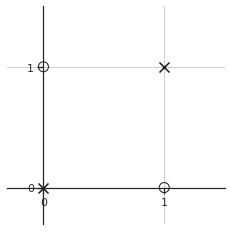

In [3]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Ignore below code block, just for formatting
sns.set_theme(style="ticks")
ax = plt.axes(aspect="equal",
              xlim=(-0.3, 1.5),
              ylim=(-0.3, 1.5),
              xticks=[0, 1],
              yticks=[0, 1])
ax.grid(True)
sns.despine(ax=ax, offset=0)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))

# Introduce variables
x = np.array([0, 1, 0, 1])
y = np.array([0, 0, 1, 1])
xor = (x ^ y).astype(np.bool_)

# Plot true as 'o'
ax.scatter(x[xor], y[xor], s=100, facecolors="none", edgecolors="k")
# Plot false as 'x'
ax.scatter(x[~xor], y[~xor], s=100, c="k", marker="x")
# Show
plt.show()

### Deep learning and multilayer perceptrons

So we need multiple layers. This is the main idea of _deep learning_: emulating
a nonlinear function with linear operations on the feature vectors plus a
nonlinear activation function. The advantages of such method are as follows:

1. **Relatively cheaper computational cost.** The cost would be even lowered if
   hardware accelerators (a.k.a. GPUs) take part.
2. **Less subject to _a priori_ knowledge to the problem.** There is no need to
   figure out the governing equation of the system of interest analytically.
   Yet, this is also true of the other numerical approximation algorithms.
3. **Easily scalable.** This is the main difference compared to the other
   machine learning algorithms. Millions of, or even billions of, parameters are
   not rare in deep learning models. Thus, complex problems related to a huge
   dataset is the main target for deep learning models.

### GPU training

#### Selecting GPUs

If multiple GPUs are connected to the machine, PyTorch automatically selects the
GPU with index `0`. If such behavior is not desirable, you may set the
environment variable `$CUDA_VISIBLE_DEVICES` to the index of the GPU to use.

Before selection, check others' GPU usage with the command `nvidia-smi`. With an
exclamation point at the beginning of the line, we could interleave shell
commands between python codes in jupyter notebooks.


In [2]:
!nvidia-smi

Sun Jan  9 17:34:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 21%   46C    P0    52W / 215W |      0MiB /  7981MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:81:00.0 Off |                  N/A |
| 37%   

Then set the env variable to the zero-based index of the CUDA device to use.
Note that this should be done in the command line or, at least, before importing
the `torch` package.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Another way to select the GPU is to explicitly set the device ID like this:

In [2]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

#### PyTorch and GPU

PyTorch can handle both CPU and GPU tensors. However, computation between CPU
and GPU tensors is forbidden; all tensors should be on the same device. The
default device in PyTorch is CPU, so this restriction is usually problematic
when we're on the GPU.

For GPU accelerated computation, PyTorch tensors and networks provide a method
called `to`. Example usage:

In [4]:
# Create a 10 * 10 tensor with random values, drawn from a normal distribution
a = torch.randn(10, 10)
print(repr(a.device))

# Send it to the GPU
a = a.to("cuda")
print(repr(a.device))

# Sending back to the CPU is also possible
a = a.to("cpu")
print(repr(a.device))

device(type='cpu')
device(type='cuda', index=0)
device(type='cpu')


Unlike tensors, the network does not provide a direct way to check its device
(i.e., no `net.device`), so the following code uses the `weight` attribute to
check the network's device. However, not all networks has the attribute we're
using, and this workaround could also fail. This is just a demonstration.


In [5]:
from torch import nn

# Create a network
net = nn.Linear(10, 10)
print(repr(net.weight.device))

net = net.to("cuda")
print(repr(net.weight.device))

net = net.to("cpu")
print(repr(net.weight.device))

device(type='cpu')
device(type='cuda', index=0)
device(type='cpu')
